In [58]:
from itertools import compress
import random
import time
import matplotlib.pyplot as plt

from data import *
from queue import PriorityQueue

In [59]:
def initial_population(individual_size, population_size):
    return [[random.choice([True, False]) for _ in range(individual_size)] for _ in range(population_size)]

def fitness(items, knapsack_max_capacity, individual): # Po co jeszcze raz to deklarować?
    total_weight = sum(compress(items['Weight'], individual))
    if total_weight > knapsack_max_capacity:
        return 0
    return sum(compress(items['Value'], individual))

def population_best(items, knapsack_max_capacity, population):
    best_individual = None
    best_individual_fitness = -1
    for individual in population:
        individual_fitness = fitness(items, knapsack_max_capacity, individual)
        if individual_fitness > best_individual_fitness:
            best_individual = individual
            best_individual_fitness = individual_fitness
    return best_individual, best_individual_fitness

# My functions:

# Parents:

## Calculates sum of fitness values in population
def fitnesses(items, knapsack_max_capacity, population):
    fs = []
    max = -1

    for i in population:
        ft = fitness(items, knapsack_max_capacity, i)
        fs.append(ft)
        if ft > max:
            max = ft
    return max, fs

## Array of chances of the roulette wheel selection
def chance_distribution(fitnesses):
    # Each individual from the population contains the starting value of it's "chance zone" at it's index
    distribution = []
    start_pos = 0
    next = 0
    fitness_sum = sum(fitnesses)

    for i in fitnesses:
        chance = i / fitness_sum
        next = chance + start_pos
        distribution.append(next)
        start_pos = next

    return distribution

## Chooses an individual at the certain "chance zone" of a roulette
def choose_individual(chance, roulette):
    index = 0
    
    for i in roulette:
        if chance < i:
            return index
        index += 1

    return len(roulette) - 1   


# Children:

## Evenly divides "genome" with one point
def children(parents_genome):
    children = [[],[]]

    parent_size = len(parents_genome) // 2
    point = parent_size // 2

    for i in range(0, parent_size):
        children[0].append(parents_genome[i + parent_size])
        children[1].append(parents_genome[i])
        if i == point: # It's time to change donor of genome
            temp = children[0]
            children[0] = children[1]
            children[1] = temp
            
    return children

## Generates indexes of pairs
def generate_pairs(n):
    # Initialize the array with the desired pattern
    array = []

    for i in range(0, n):
        pairs = []
        for j in range(0, n):
            if j != i:
                pairs.append(j)
        array.append(pairs)

    return array


## Generates children for all the parents from set
def generate_children(parents_population):
    result = []
    parents_count = len(parents_population)

    # Array of sets for every index. Each set contains possible pairs
    pairs = generate_pairs(parents_count)
    paired = []
    paired.append(0)

    # generate children for pairs
    for p in range(0, parents_count):
        # We want to skip parents which are already paired
        if p in paired:
            continue

        partners_available = len(pairs[p])

        if partners_available == 1:
            partner = pairs[p][0]
        elif partners_available <= 0:
            continue
        else:
            partner = random.randrange(0, partners_available) #choosing random partner
        
        paired.append(partner)
        
        # Remove both parents from the list of future pairs
        for rp in range(p + 1, parents_count):
            if rp in paired:
                continue
            if p in pairs[rp]:
                pairs[rp].remove(p)
            if partner in pairs[rp]:
                pairs[rp].remove(partner)

        pair_result = children(parents_population[p] + parents_population[partner])
        
        # Some hardcoded values
        result.append(pair_result[0])
        result.append(pair_result[1])

    return result

## Seeks for top n elites to keep in the population (returns the array of indexes)
def get_elites(items, knapsack_max_capacity, population, best_fitness, n_elites):
    elites = []
    size = len(population)

    best = PriorityQueue()

    for index in range(0, size):
        normalized_priority = fitness(items, knapsack_max_capacity, population[index]) * 100 / best_fitness
        best.put((-normalized_priority, index))

    for j in range(0, n_elites):
        _, elite_index = best.get()
        elites.append(elite_index)

    return elites


# Mutation:

## Changes random bit in a choosen solution
def mutate(individual):
    index = random.randrange(0, len(individual))
    
    individual[index] = not individual[index]

    return individual 

def mutate_population(population):
    for i in population:
        i = mutate(i)
        
    return population
    

In [60]:
items, knapsack_max_capacity = get_big()
print(items)

               Name  Weight    Value
0               Axe   32252    68674
1       Bronze coin  225790   471010
2             Crown  468164   944620
3    Diamond statue  489494   962094
4      Emerald belt   35384    78344
5            Fossil  265590   579152
6         Gold coin  497911   902698
7            Helmet  800493  1686515
8               Ink  823576  1688691
9         Jewel box  552202  1056157
10            Knife  323618   677562
11       Long sword  382846   833132
12             Mask   44676    99192
13         Necklace  169738   376418
14       Opal badge  610876  1253986
15            Perls  854190  1853562
16           Quiver  671123  1320297
17        Ruby ring  698180  1301637
18  Silver bracelet  446517   859835
19        Timepiece  909620  1677534
20          Uniform  904818  1910501
21     Venom potion  730061  1528646
22       Wool scarf  931932  1827477
23        Cross bow  952360  2068204
24  Yesteryear book  926023  1746556
25         Zinc cup  978724  2100851


In [61]:
population_size = 100
generations = 200
n_selection = 20
n_elite = 1

start_time = time.time()
best_solution = None
best_fitness = 0
population_history = []
best_history = []
population = initial_population(len(items), population_size)

In [62]:
for _ in range(generations):
    population_history.append(population)

    # TODO: implement genetic algorithm

    # TODO: wybór rodziców
    max_fit, fsum = fitnesses(items, knapsack_max_capacity, population)
    roulette = chance_distribution(fsum) 
    # example of roulette: [0.0, 0.0, 0.04, 0.24, 0.45, 0.69, 0.81, 0.81, 0.82, 0.99, 1.0]

    selected_indexes = set() # set of unique indexes

    for i in range(0, n_selection):
        index = choose_individual(random.randrange(0, 100) / 100, roulette) # index of chosen individual
        selected_indexes.add(index)

    # TODO: tworzenie dzieci
    parents_population = []

    for parent_index in selected_indexes:
        parents_population.append(population[parent_index])

    new_population = generate_children(parents_population)

    # TODO: mutacja 
    new_population = mutate_population(new_population)

    # TODO: aktualizacja populacji
    elites_indexes = get_elites(items, knapsack_max_capacity, population, max_fit, n_elite)

    for ind in elites_indexes:
        new_population.append(population[ind])

    population = new_population

    best_individual, best_individual_fitness = population_best(items, knapsack_max_capacity, population)
    if best_individual_fitness > best_fitness:
        best_solution = best_individual
        best_fitness = best_individual_fitness
    best_history.append(best_fitness)

In [63]:
end_time = time.time()
total_time = end_time - start_time
print('Best solution:', list(compress(items['Name'], best_solution)))
print('Best solution value:', best_fitness)
print('Time: ', total_time)

Best solution: ['Axe', 'Emerald belt', 'Fossil', 'Helmet', 'Jewel box', 'Knife', 'Mask', 'Necklace', 'Opal badge', 'Uniform', 'Venom potion', 'Cross bow', 'Zinc cup']
Best solution value: 13484202
Time:  0.10811352729797363


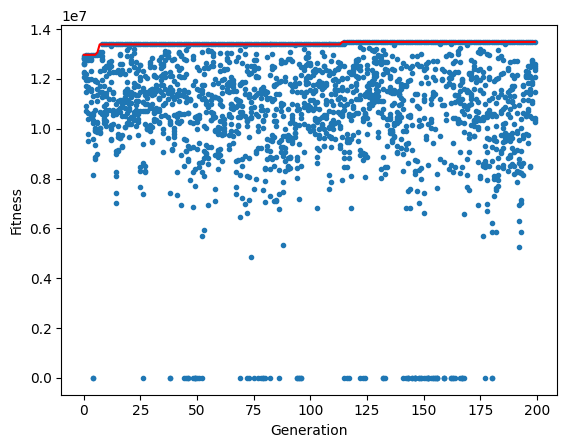

In [64]:
# plot generations
x = []
y = []
top_best = 10
for i, population in enumerate(population_history):
    plotted_individuals = min(len(population), top_best)
    x.extend([i] * plotted_individuals)
    population_fitnesses = [fitness(items, knapsack_max_capacity, individual) for individual in population]
    population_fitnesses.sort(reverse=True)
    y.extend(population_fitnesses[:plotted_individuals])
plt.scatter(x, y, marker='.')
plt.plot(best_history, 'r')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()